## Overview

Perform some analysis of IBD, specifically:

- Plot summaries of IBD data (total IBD, no. tracts), comparing within and between sampling sites.

- Perhaps a network?

In [1]:
%run setup.ipynb

In [2]:
marker_style = {
    'GHcol' : 'D',
    'GHgam' : 'o',
    'BFgam' : 'o',
    'BFcol' : 'D',
    'UGgam' : 'o',
    'GM' : '*',
    'GW' : '*',
    'KE' : '*',
    'CMgam' : 'o',
    'FRgam' : 'o', 
    'GQgam' : 'o', 
    'AOcol' : 'D', 
    'GAgam' : 'o', 
    'GNgam' : 'o', 
    'GNcol' : 'D', 
    'CIcol' : 'D'
}

In [3]:
from itertools import combinations
from intervaltree import Interval, IntervalTree
from pathlib import Path

In [4]:
import logging
LOGFORMAT = '%(asctime)s : %(levelname)s : %(message)s'
logging.basicConfig(format=LOGFORMAT, level=logging.INFO, datefmt="%Y-%m-%d %H:%M:%S")


In [5]:
# plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('darkgrid')
# sns.set_context('paper')
plt.rcParams['figure.dpi'] = 120
%config InlineBackend.figure_formats = {'retina', 'png'}

In [6]:
regions = {
    "3R": (1000000, 37000000),
    "3L": (15000000, 41000000)}

In [7]:
seqs = sorted(regions.keys())

In [8]:
starts = [regions[c][0] for c in seqs]
ends = [regions[c][1] for c in seqs]

In [9]:
seqs, starts, ends

(['3L', '3R'], [15000000, 1000000], [41000000, 37000000])

In [10]:
ibd_data = Path("/kwiat/vector/ag1000g/analysis/20180625-IBD-phase2", "output")

In [11]:
genome = phase2_ar1.genome_agamp3

In [12]:
IBDCOLS = ["sample1", "i1", "sample2", "i2", "chrom", "start", "end", "LOD"]
def load_raw_ibd(seqid, popid, min_chunk_size):
    
    fn = ibd_data / seqid / (popid + ".ibd")
    logging.info("loading {0}".format(fn))
    df = pd.read_table(fn, names=IBDCOLS)
    df["chunk_size"] = df.end - df.start
    return df.query("chunk_size >= @min_chunk_size")

In [14]:
g = df.groupby(["sample1", "sample2"])

In [36]:
def get_IBD(chrom, start, stop, pop, samples, min_size=100000):
        
    if not isinstance(chrom, str):
        f  = {}
        for _c, _s, _e in zip(chrom, start, stop):
            f[_c] = get_IBD(_c, _s, _e, pop, samples, min_size)

        f = pd.concat(f).groupby(level=[1, 2]).aggregate(sum)
        
    else:
        
        ibddf = load_raw_ibd(chrom, pop, min_size)
        all_combs = list(combinations(samples, 2))
        logging.info("Loaded {0} {1}: processing...".format(chrom, pop))
        
        mi = pd.MultiIndex.from_tuples(all_combs, names=["Sample1", "Sample2"])
        f = pd.DataFrame(
            data=0, 
            index=mi, 
            columns=["IBDsum", "IBDcount", "IBDmediansize"])

        # cut the start and stop
        g = ibddf.groupby(["sample1", "sample2"])
        
        for spair, df in g:
            
            x = df[["start", "end"]]
            tree = IntervalTree.from_tuples(x.to_records(index=False))
                
            tree.chop(1, start)
            tree.chop(stop, len(genome[chrom]))
            ibdlens = [iv.length() for iv in tree]
            f.loc[spair] = sum(ibdlens), len(tree), np.median(ibdlens)
            del tree
        
    return f

In [37]:
ibd_dict = {
    pop: get_IBD(
        seqs, starts, ends,
        pop, 
        sorted(phase2_ar1.df_samples.query("population == @pop").index),
        min_size=0) for pop in phase2_ar1.pop_ids}

2019-07-10 15:10:26 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/AOcol.ibd
2019-07-10 15:10:26 : INFO : Loaded 3L AOcol: processing...
/home/njh/git/ag1000g-phase2-data-paper/binder/deps/conda/envs/ag1000g-phase2-data-paper/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/njh/git/ag1000g-phase2-data-paper/binder/deps/conda/envs/ag1000g-phase2-data-paper/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
2019-07-10 15:10:32 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/AOcol.ibd
2019-07-10 15:10:32 : INFO : Loaded 3R AOcol: processing...
2019-07-10 15:10:37 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/GHcol.ibd
2019-07-10 15:10:37 : INFO : Loaded 3L GHcol: processing...
2019-07-10 15:10:40 : INFO : loading /kwiat/vect

In [43]:
all_pop_sum.loc["BFgam"].IBDcount.describe()

count    4186.000000
mean       23.709986
std         4.936585
min         9.000000
25%        20.000000
50%        24.000000
75%        27.000000
max        42.000000
Name: IBDcount, dtype: float64

In [44]:
all_pop_sum.loc["CMgam"].IBDcount.describe()

count    43956.000000
mean        64.145236
std         11.845128
min          2.000000
25%         57.000000
50%         65.000000
75%         72.000000
max        151.000000
Name: IBDcount, dtype: float64

In [42]:
all_pop_sum.loc["BFgam"].IBDmediansize.describe()

count      4186.000000
mean      19968.829193
std        8475.365048
min        8365.500000
25%       15451.500000
50%       18323.000000
75%       22266.500000
max      294430.000000
Name: IBDmediansize, dtype: float64

In [45]:
all_pop_sum.loc["CMgam"].IBDmediansize.describe()

count    4.395600e+04
mean     6.501921e+04
std      1.572461e+06
min      4.519000e+03
25%      9.544875e+03
50%      1.041925e+04
75%      1.146700e+04
max      6.200000e+07
Name: IBDmediansize, dtype: float64

In [38]:
all_pop_sum = pd.concat(ibd_dict, names=["population"])

In [39]:
all_pop_sum.sort_values("IBDsum", ascending=False).head(10)

IBDsum  IBDcount  IBDmediansize
population Sample1  Sample2                                    
AOcol      AR0042-C AR0049-C  62000000         2     62000000.0
CMgam      AN0142-C AN0169-C  62000000         2     62000000.0
           AN0020-C AN0169-C  62000000         2     62000000.0
           AN0085-C AN0107-C  62000000         2     62000000.0
           AN0147-C AN0179-C  62000000         2     62000000.0
           AN0171-C AN0205-C  62000000         2     62000000.0
           AN0020-C AN0142-C  62000000         2     62000000.0
           AN0124-C AN0183-C  62000000         2     62000000.0
           AN0154-C AN0193-C  62000000         2     62000000.0
           AN0010-C AN0171-C  62000000         2     62000000.0

In [19]:
all_pop_sum["log_IBDsum"] = np.log(all_pop_sum.IBDsum)

/home/njh/git/ag1000g-phase2-data-paper/binder/deps/conda/envs/ag1000g-phase2-data-paper/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


<Figure size 1440x960 with 0 Axes>

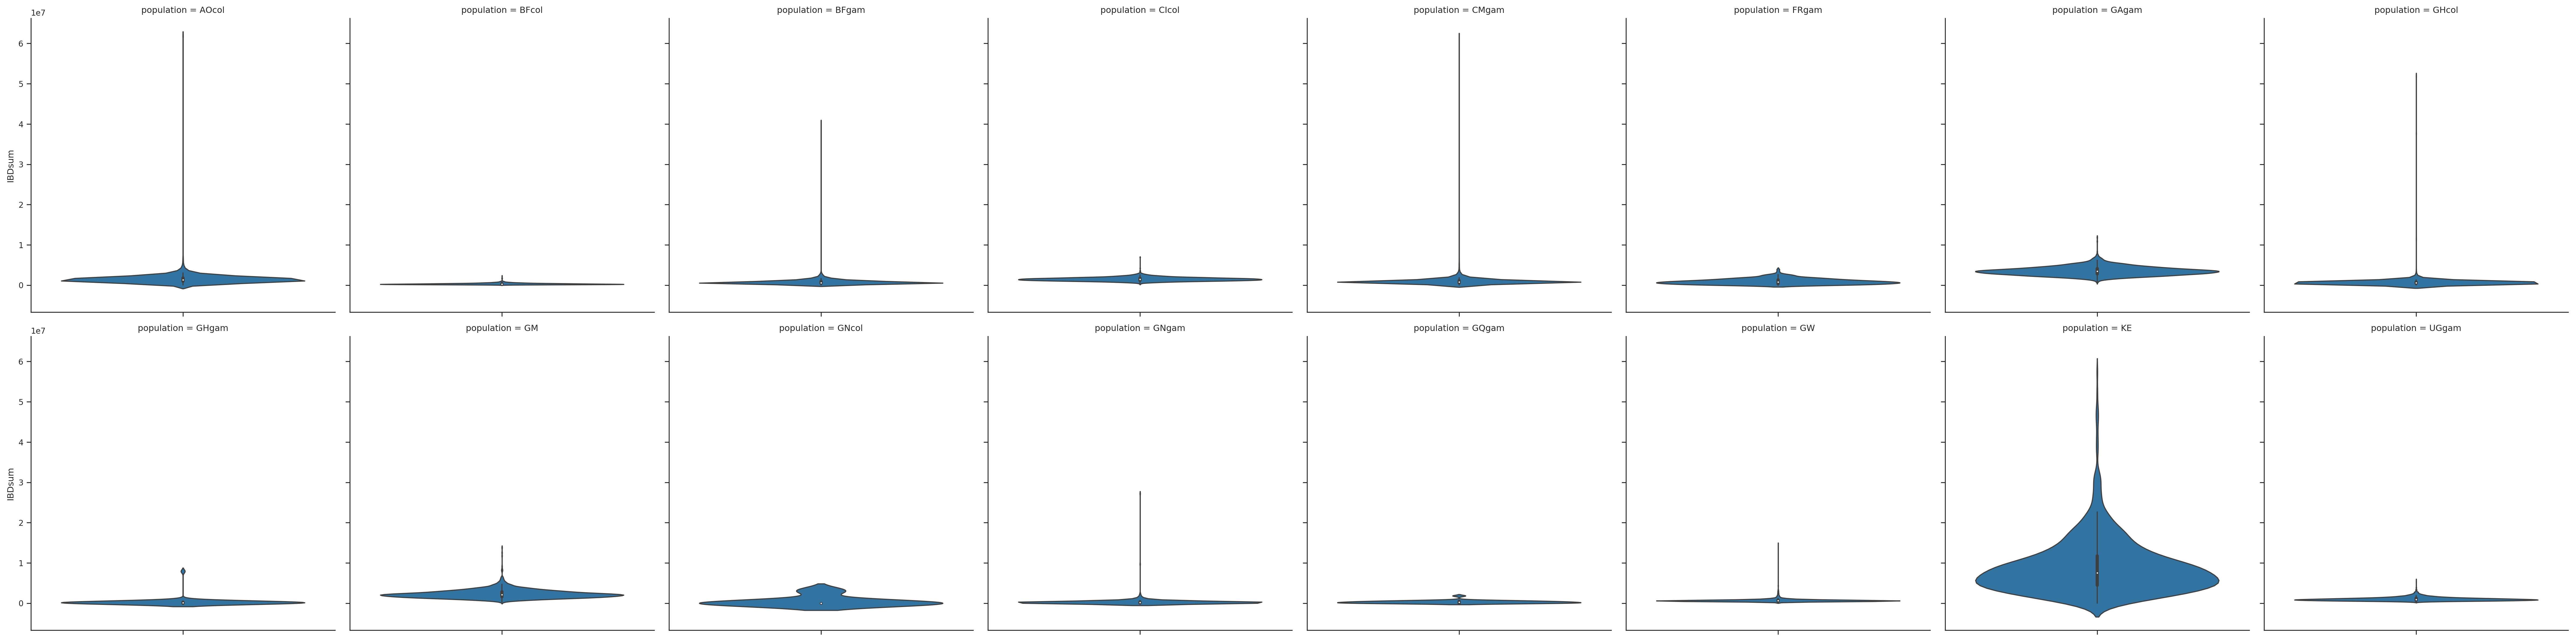

In [20]:
f = plt.figure(figsize=(12, 8))
sns.catplot(y="IBDsum", col="population", kind="violin", col_wrap=8, data=all_pop_sum.reset_index())

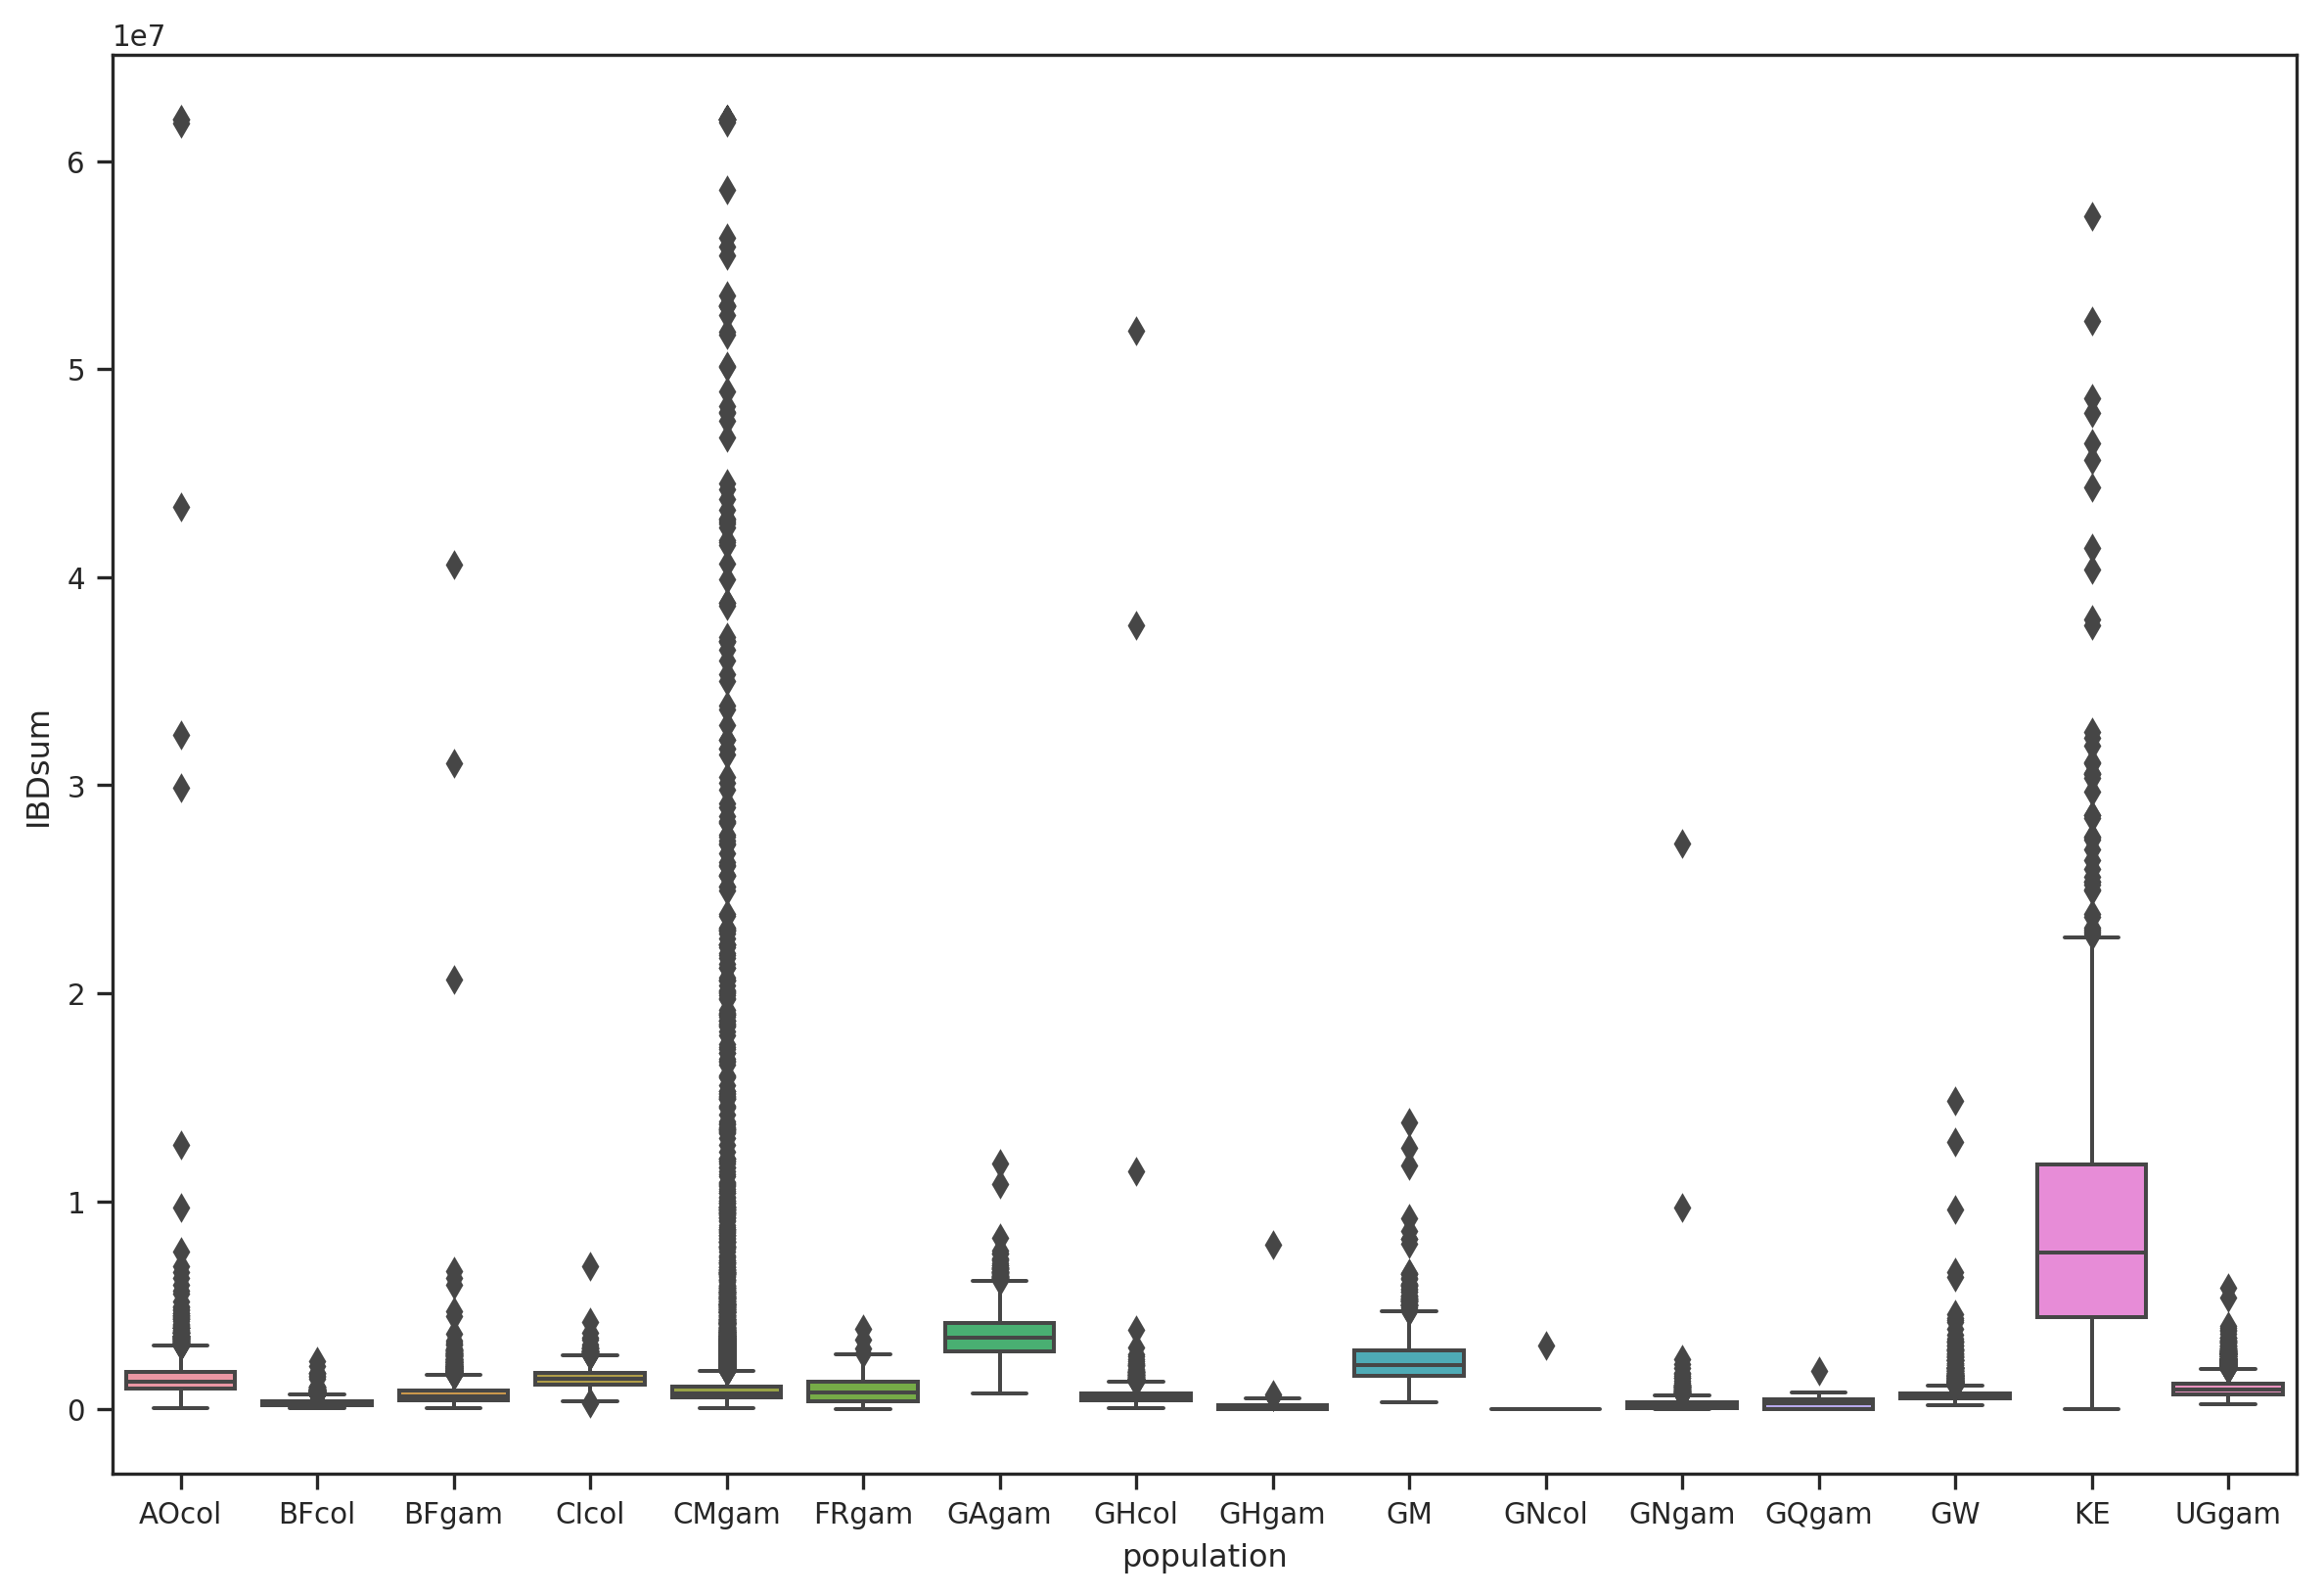

In [21]:
f = plt.figure(figsize=(12, 8))
sns.boxplot(y="IBDsum", x="population", data=all_pop_sum.reset_index())

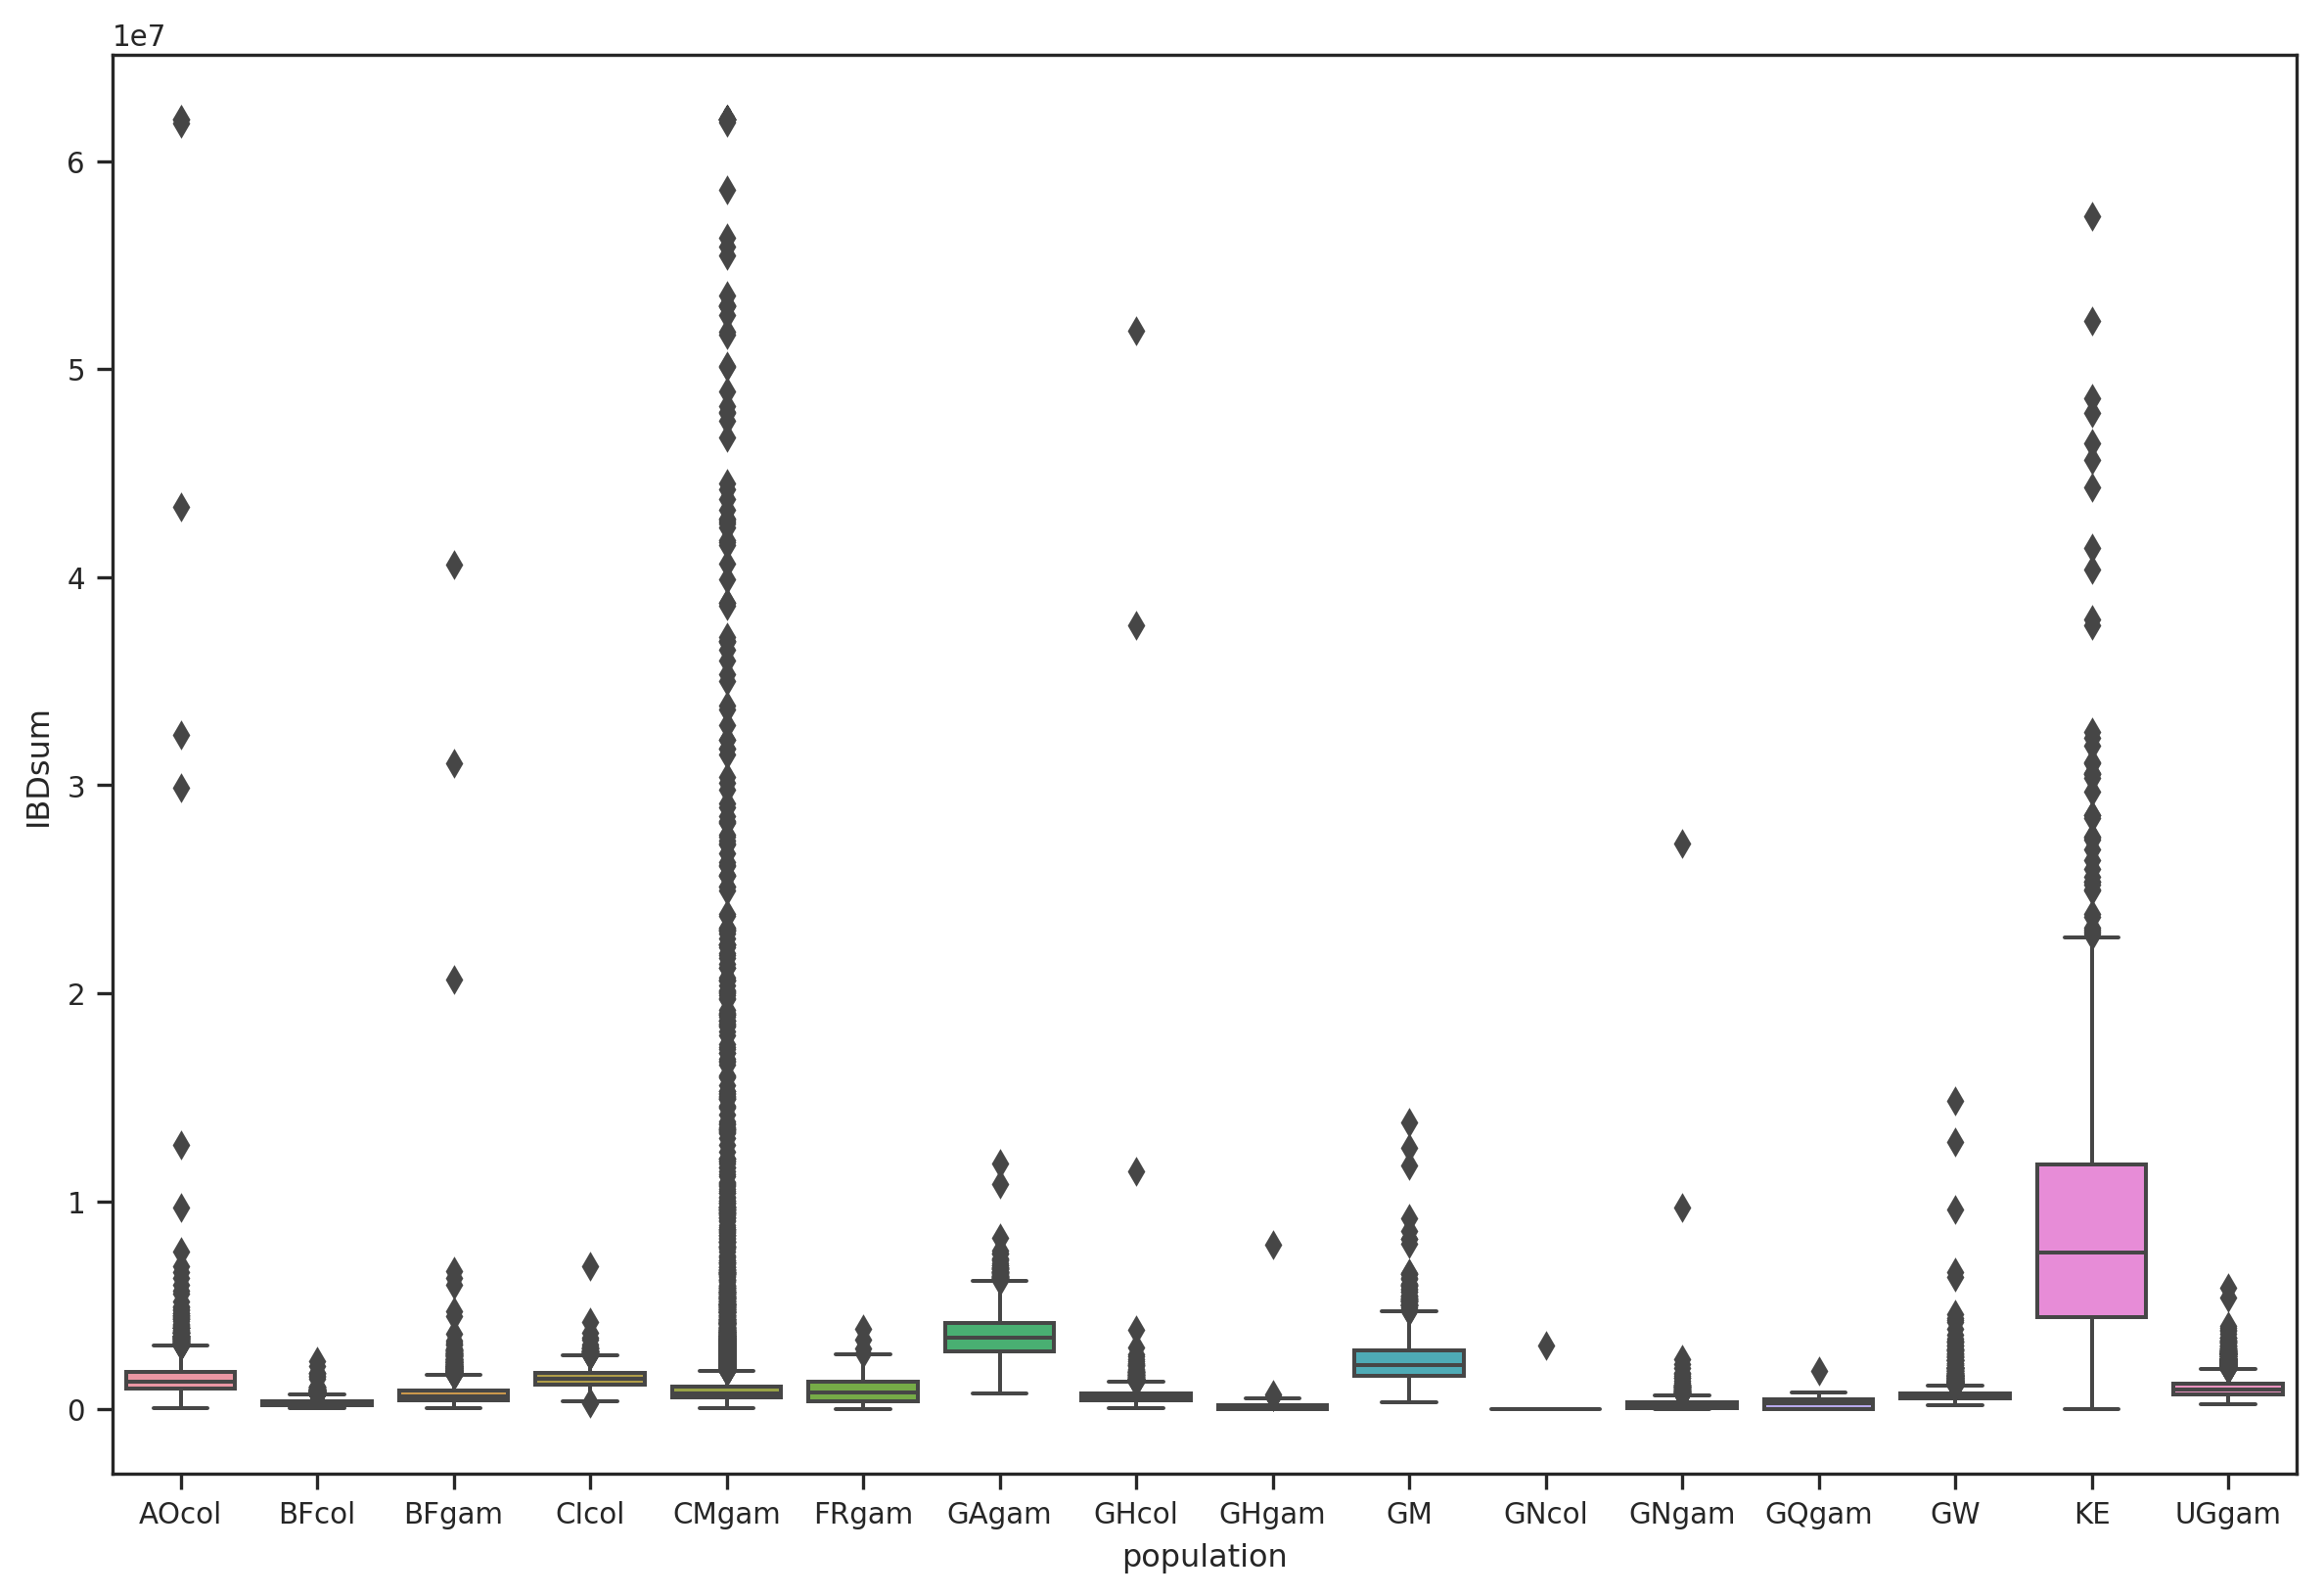

In [22]:
f = plt.figure(figsize=(12, 8))
sns.boxplot(y="IBDsum", x="population", data=all_pop_sum.reset_index())

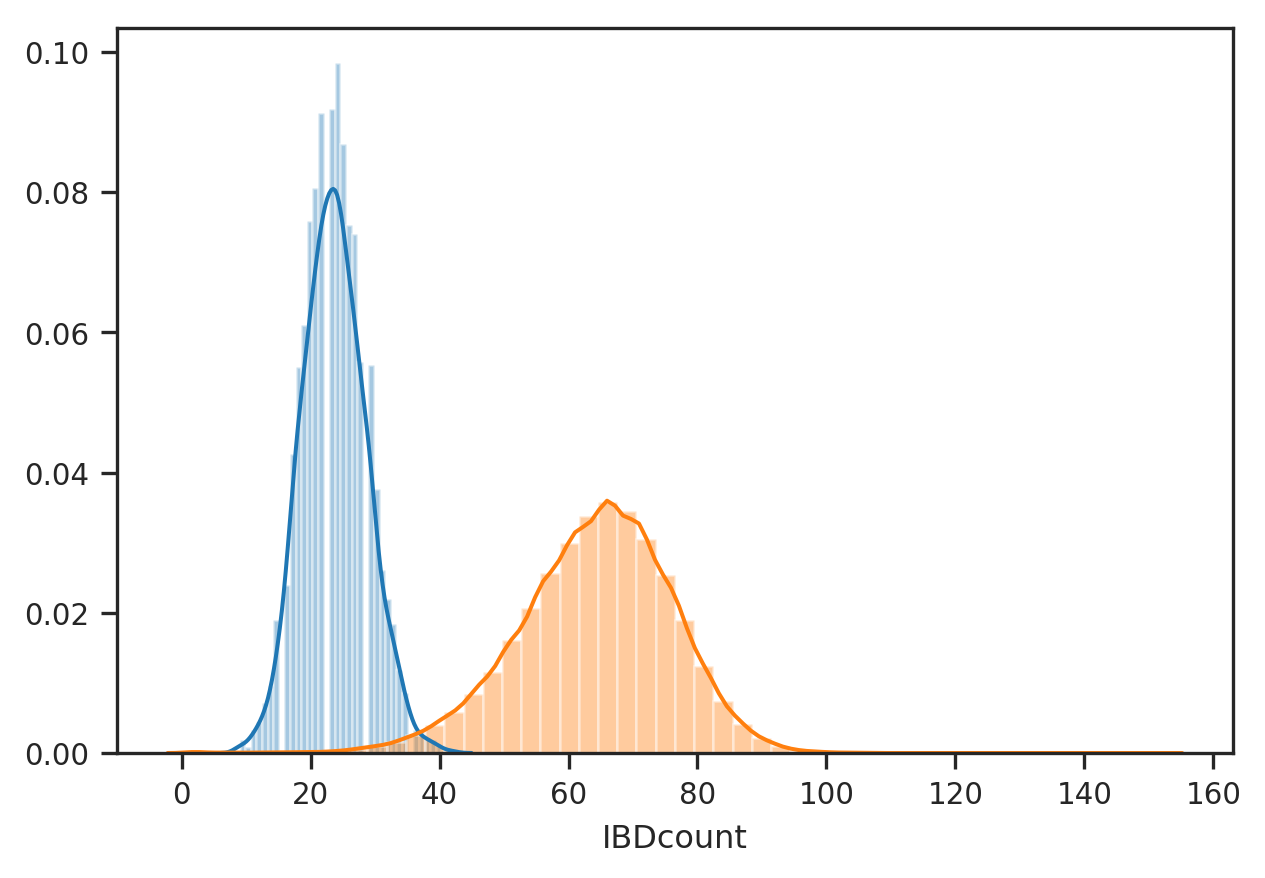

In [34]:
sns.distplot(ibd_dict["BFgam"].IBDcount)
sns.distplot(ibd_dict["CMgam"].IBDcount)

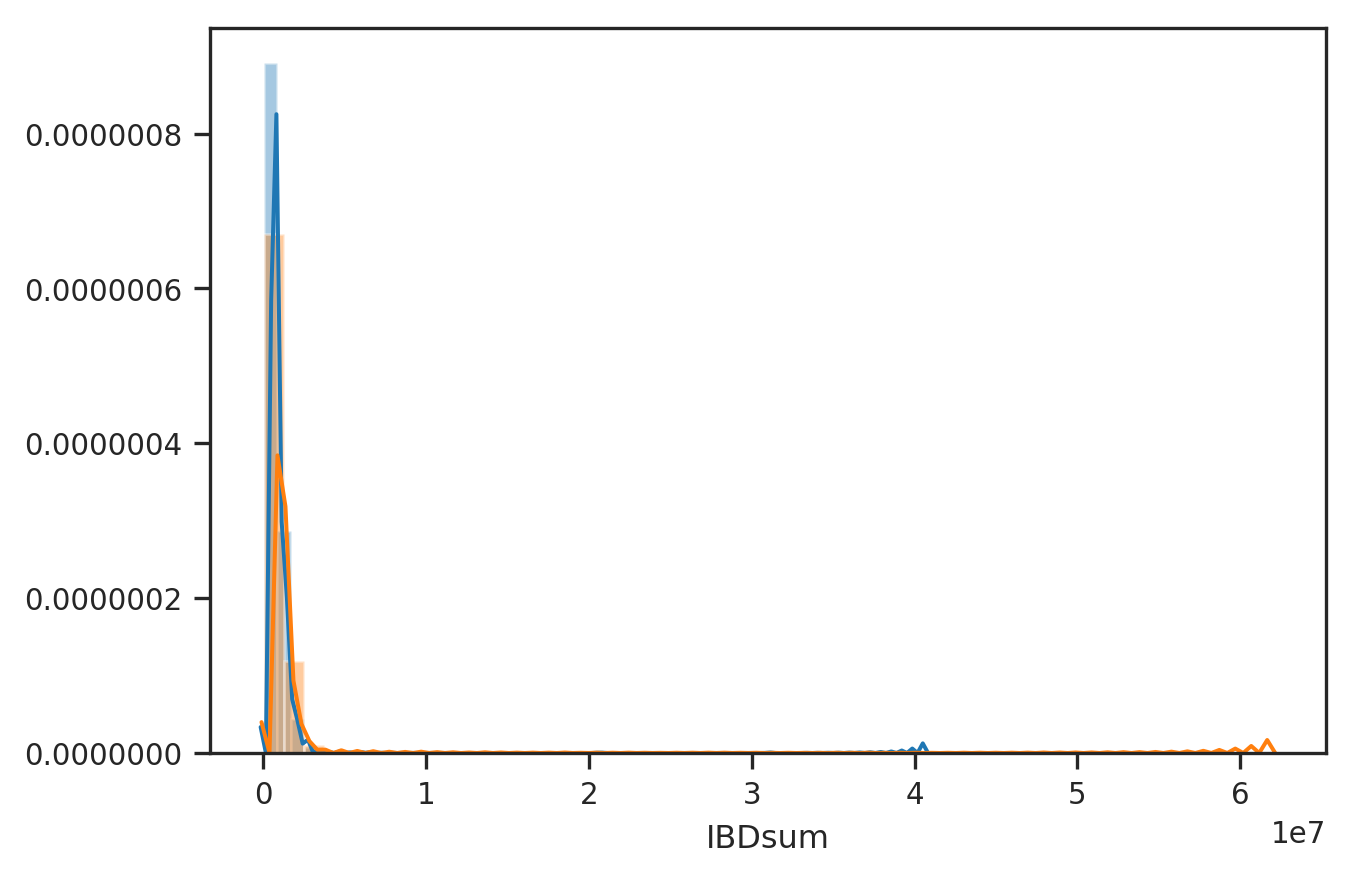

In [35]:
sns.distplot(ibd_dict["BFgam"].IBDsum)
sns.distplot(ibd_dict["CMgam"].IBDsum)

In [31]:
ibd_dict["CMgam"]

IBDsum  IBDcount
Sample1  Sample2                     
AN0007-C AN0008-C    662255        64
         AN0009-C    550580        64
         AN0010-C    361606        36
         AN0011-C    903380        73
         AN0012-C    779397        78
         AN0013-C    981940        69
         AN0014-C    443486        60
         AN0015-C    502274        52
         AN0016-C   1601385        65
         AN0017-C   1895295        87
         AN0018-C   1216326        71
         AN0019-C   2079593        55
         AN0020-C    495583        60
         AN0022-C   1034187        63
         AN0023-C    840206        61
         AN0024-C   1000693        94
         AN0025-C    353539        57
         AN0026-C    582599        58
         AN0027-C   1300244        72
         AN0028-C    990691        81
         AN0029-C    442103        54
         AN0030-C    520209        52
         AN0031-C   1234694        64
         AN0032-C    551080        69
         AN0033-C    611689        64
         AN0034-C    537894        55
         AN0035-C   1010214        62
         AN0036-C   1019207        71
         AN0037-C    756687        67
         AN0038-C   1128967        68
...                     ...       ...
AN0313-C AN0320-C    822210        74
         AN0321-C    577920        72
AN0314-C AN0315-C    728138        71
         AN0316-C    802309        72
         AN0317-C    836246        79
         AN0318-C    745300        71
         AN0319-C    957994        71
         AN0320-C    716425        76
         AN0321-C   1634909        80
AN0315-C AN0316-C    524422        66
         AN0317-C    645199        53
         AN0318-C    473117        55
         AN0319-C   1781070        85
         AN0320-C   2128439        55
         AN0321-C   1092394        75
AN0316-C AN0317-C    567561        68
         AN0318-C    738364        65
         AN0319-C    901109        66
         AN0320-C    625572        71
         AN0321-C    648021        70
AN0317-C AN0318-C   1202319        72
         AN0319-C    453356        57
         AN0320-C  20658139        53
         AN0321-C    967807        63
AN0318-C AN0319-C   1416491        82
         AN0320-C    874063        62
         AN0321-C    490974        55
AN0319-C AN0320-C   1059593        67
         AN0321-C    547450        62
AN0320-C AN0321-C   1324850        56

[43956 rows x 2 columns]

In [23]:
median_values = all_pop_sum.groupby(level="population").agg(np.median)

In [24]:
sorted_med_ibd = median_values.IBDsum.sort_values(ascending=False)

In [25]:
sorted_med_ibd

population
KE       7512280.0
GAgam    3428489.5
GM       2136311.0
CIcol    1452996.0
AOcol    1341674.0
UGgam     934200.0
FRgam     785521.0
CMgam     770577.0
GW        610253.0
BFgam     608840.5
GHcol     576987.0
BFcol     269093.0
GQgam     265738.0
GNgam     160278.0
GHgam     132385.5
GNcol          0.0
Name: IBDsum, dtype: float64

KE 1000
GAgam 1000
GM 1000
CIcol 1000
AOcol 1000
UGgam 1000
FRgam 276
CMgam 1000
GW 1000
BFgam 1000
GHcol 1000
BFcol 1000
GQgam 36
GNgam 780
GHgam 66
GNcol 6


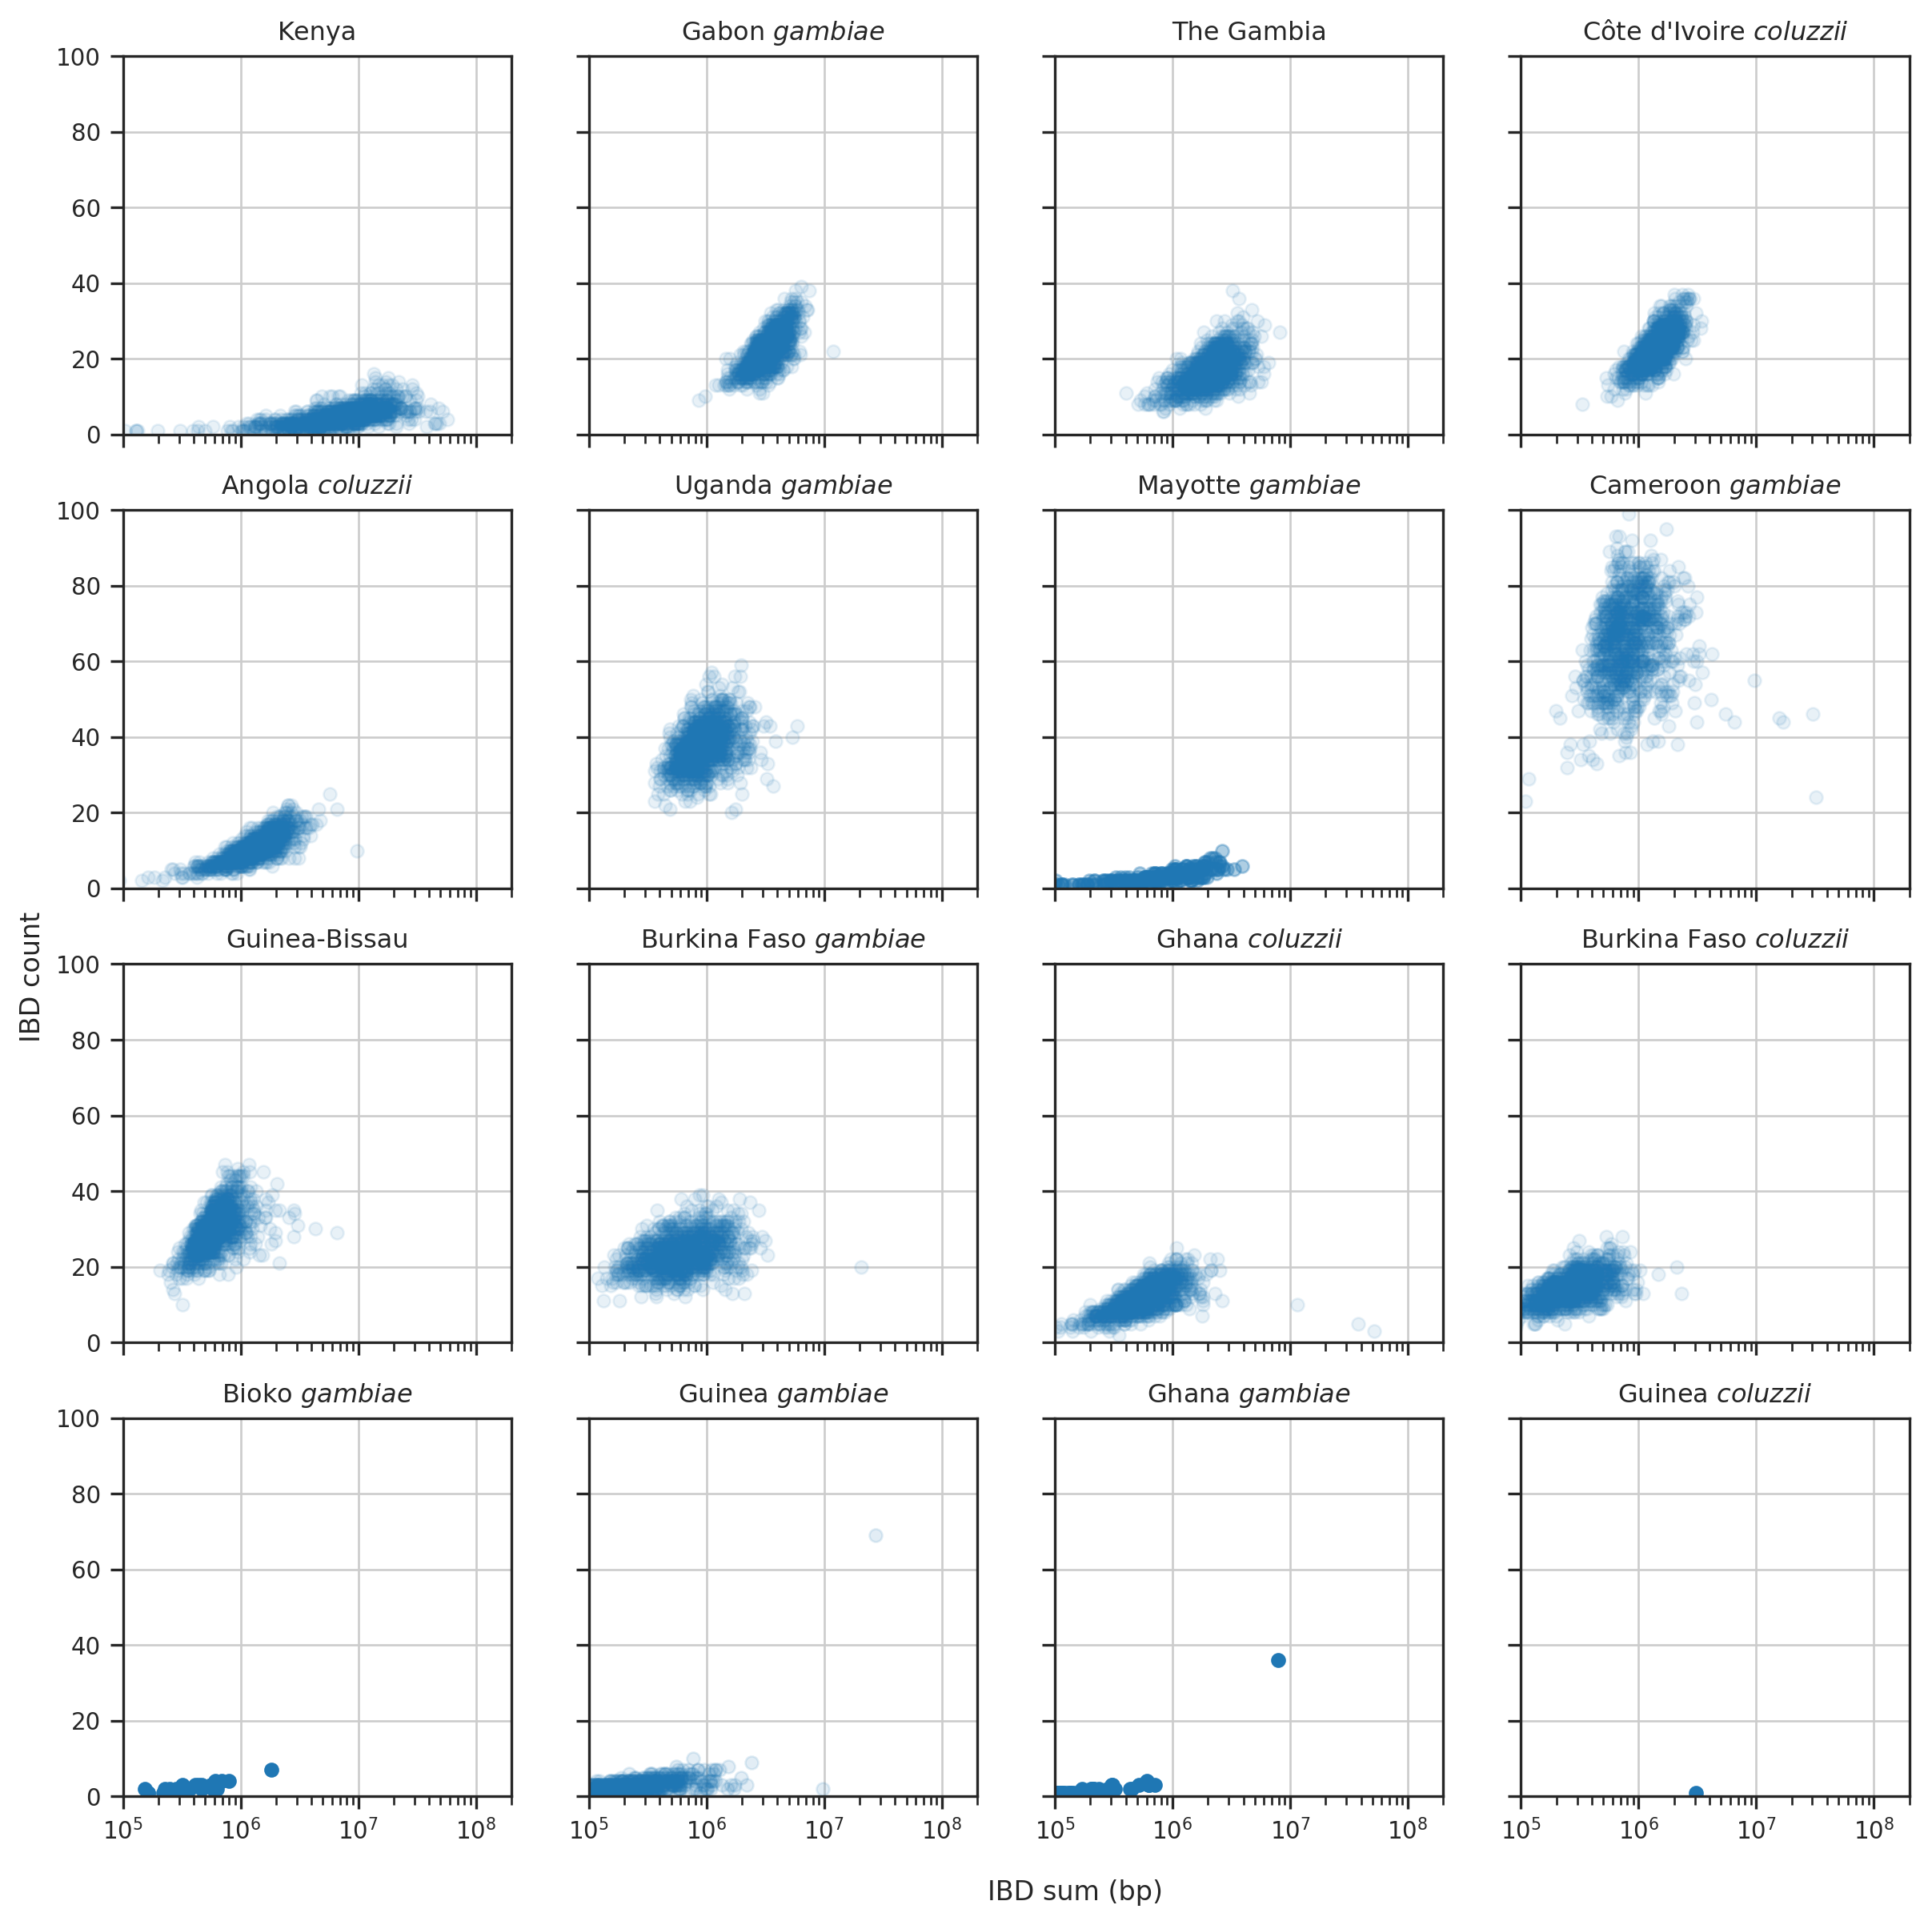

In [26]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for ix, pop in enumerate(sorted_med_ibd.index):
    
    i = (ix // 4)
    j = (ix % 4)
    
    ax = axes[i, j]
    
    ibd = ibd_dict[pop].sample(min(ibd_dict[pop].shape[0], 1000))
    n = ibd.shape[0]
    print(pop, n)
    aph = min(1.0, 100/n)
    ax.scatter(ibd.IBDsum, ibd.IBDcount, alpha=aph)
    ax.set_xscale("log", nonposx='clip')
    ax.set_xlim((10**5, 2 * 10**8))
    ax.set_ylim((0, 100))
    ax.set_title(phase2_ar1.pop_labels[pop])
    ax.grid(True)
    if i < 3:
        ax.set_xticklabels([])
    if j > 0:
        ax.set_yticklabels([])
        
fig.text(0.08, 0.5, rotation=90, s="IBD count")
fig.text(0.5, 0.08, rotation=0, s="IBD sum (bp)")
fig.savefig("../artwork/ibd/ibd_panel_populations.png", bbox_inches="tight", dpi=300)

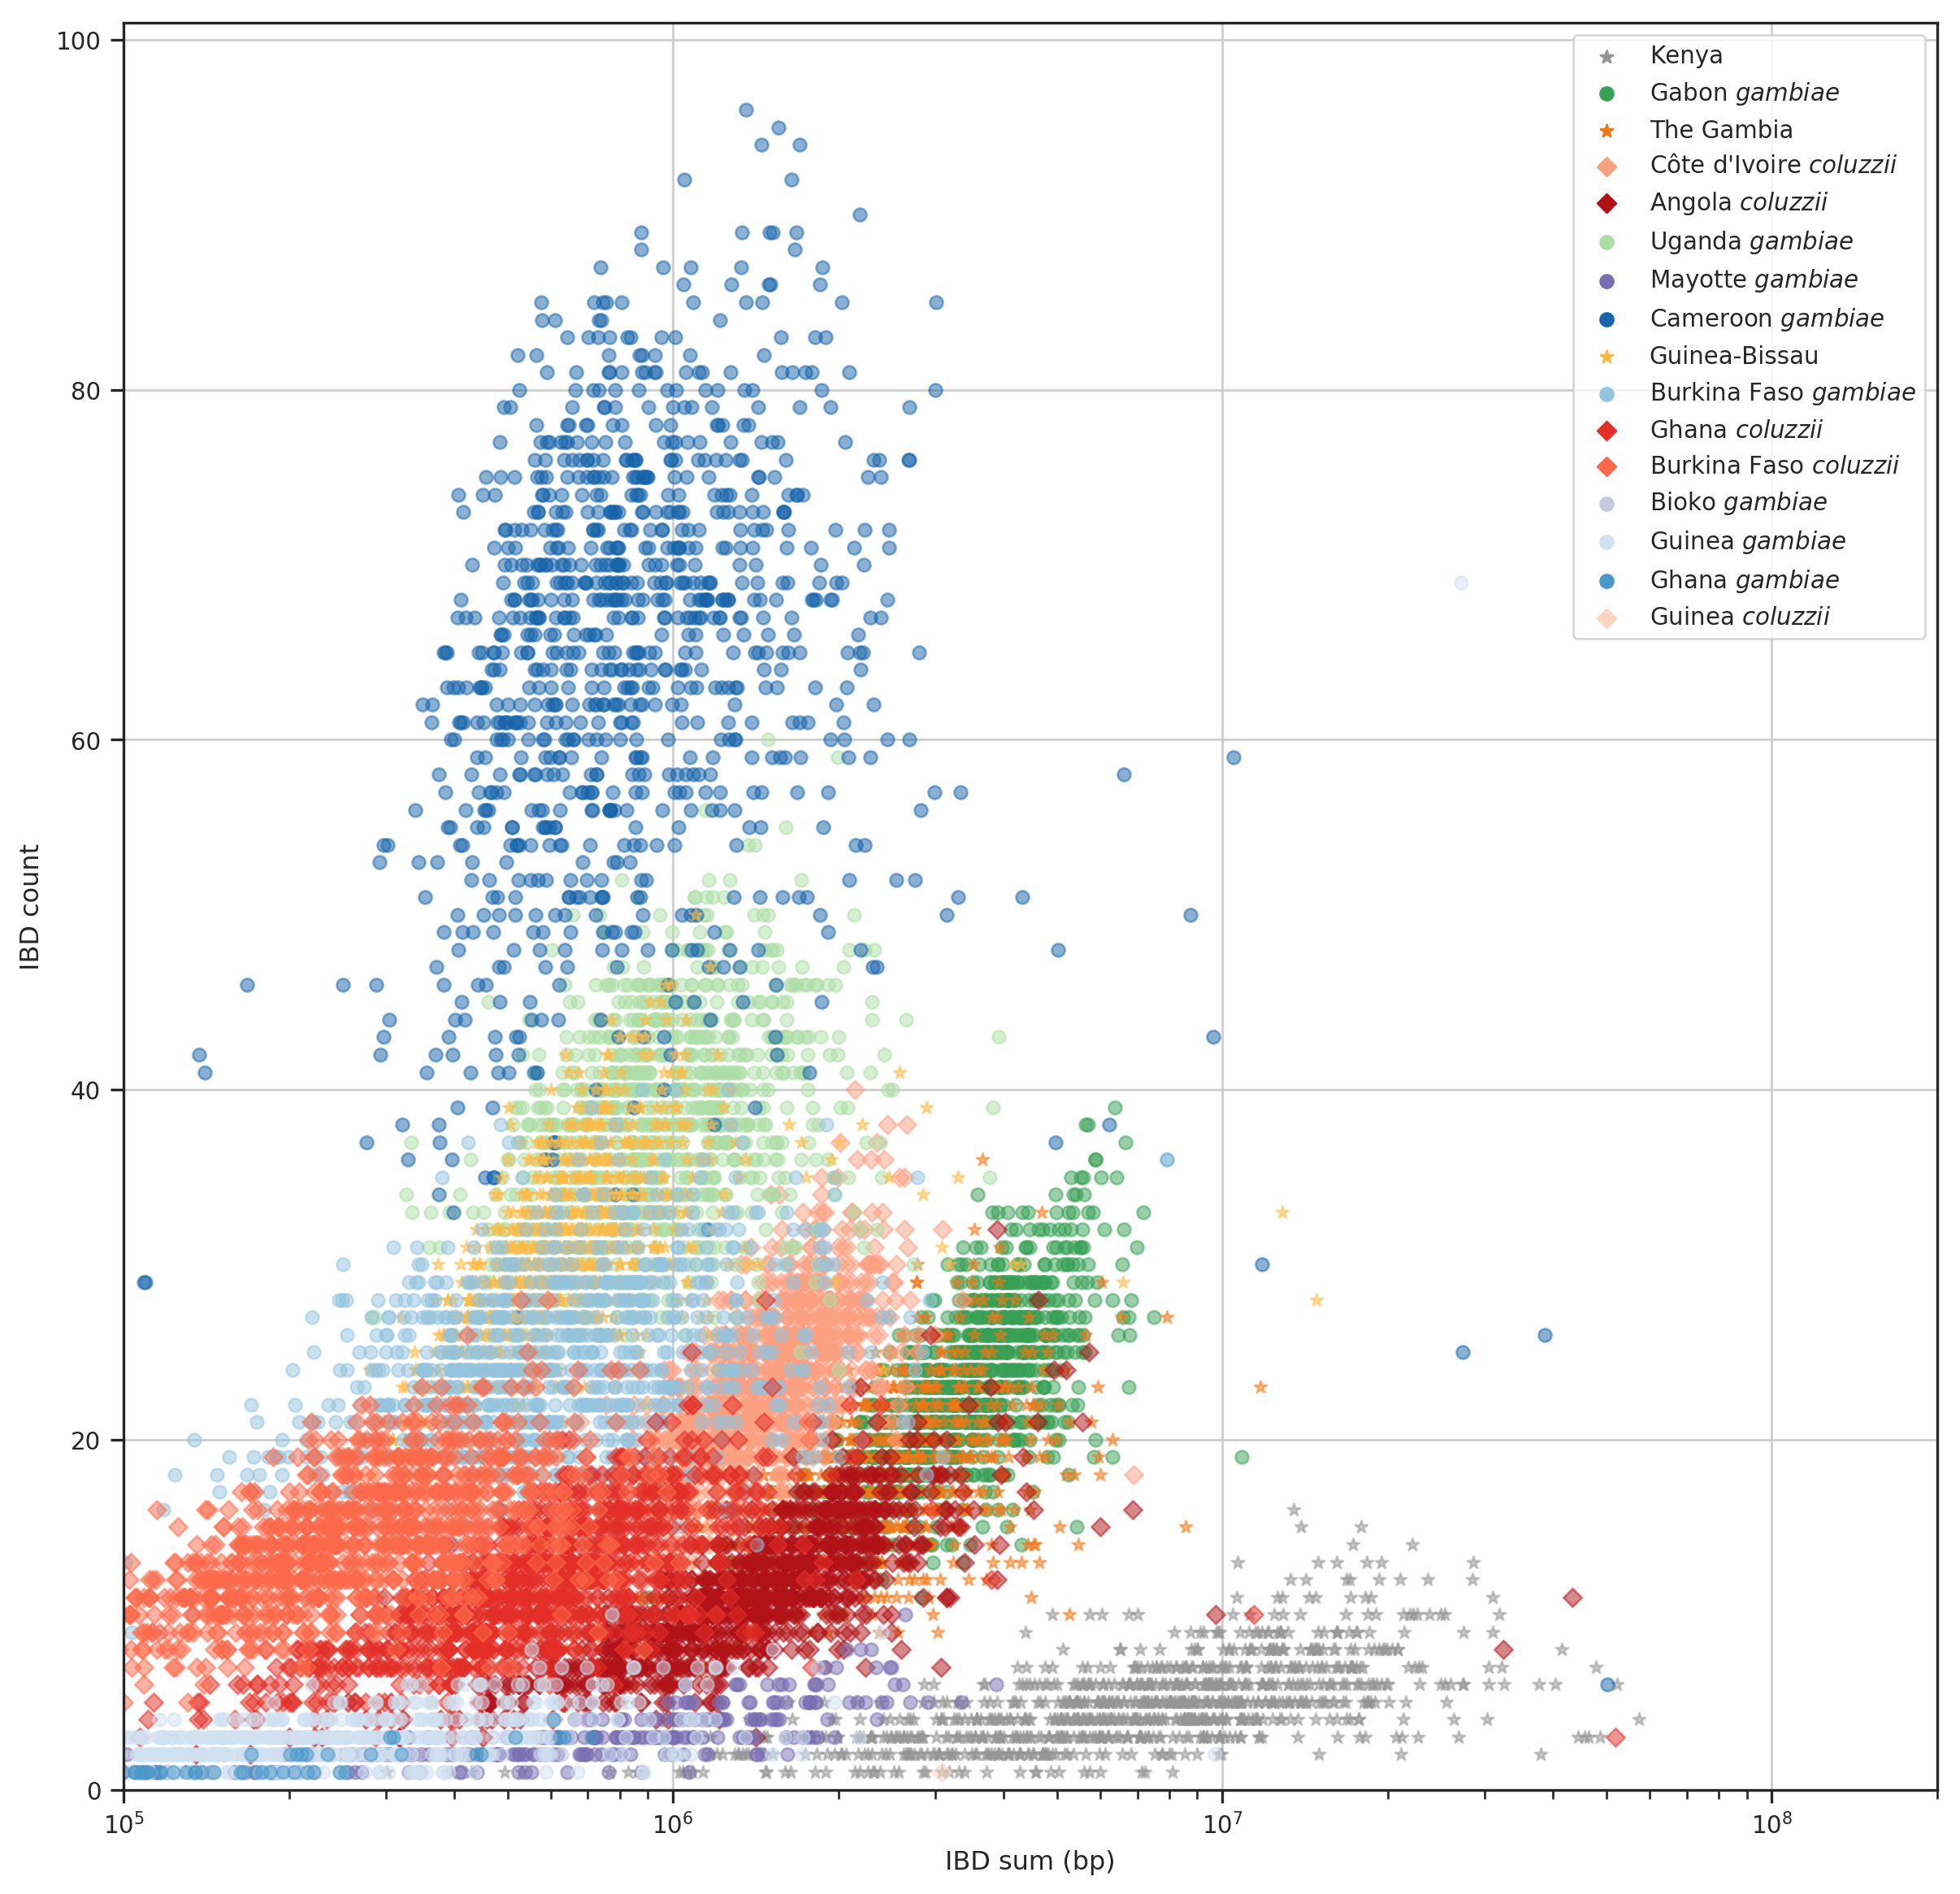

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))

for ix, pop in enumerate(sorted_med_ibd.index):
        
    ibd = ibd_dict[pop].sample(min(ibd_dict[pop].shape[0], 1000))
    ax.scatter(
        ibd.IBDsum, 
        ibd.IBDcount, 
        alpha=0.5, 
        c=(phase2_ar1.pop_colors[pop],),
        marker=marker_style[pop],
        label=phase2_ar1.pop_labels[pop])
    
    ax.set_xscale("log", nonposx='clip')

ax.set_xlim((10**5, 2 * 10**8))
ax.set_ylim(bottom=0)
ax.grid(True)
leg = ax.legend()
ax.set_ylabel("IBD count")
ax.set_xlabel("IBD sum (bp)")

for lh in leg.legendHandles: 
    lh.set_alpha(1.0)

fig.savefig(
    "../artwork/ibd/ibd_all_populations.png", 
    bbox_inches="tight", 
    dpi=300)

## Filtering by size

This is slow and a bit inefficient.

In [107]:
IBD_count_stats = {}
IBD_sum_stats = {}

for pop in sorted_med_ibd.index:

    for m in (0, 1000, 10000, 20000, 50000, 100000, 250000, 500000):

        q = get_IBD(
            seqs, starts, ends, pop, 
            samples=sorted(
                phase2_ar1.df_samples.query("population == @pop").index), min_size=m)

        IBD_count_stats[pop, m] = q.IBDcount.aggregate([np.mean, np.median, np.max, np.min])
        IBD_sum_stats[pop, m] = q.IBDsum.aggregate([np.mean, np.median, np.max, np.min])

2019-05-30 16:39:17 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/KE.ibd
2019-05-30 16:39:17 : INFO : Loaded 3L KE: processing...
2019-05-30 16:39:18 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/KE.ibd
2019-05-30 16:39:18 : INFO : Loaded 3R KE: processing...
2019-05-30 16:39:19 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/KE.ibd
2019-05-30 16:39:19 : INFO : Loaded 3L KE: processing...
2019-05-30 16:39:20 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/KE.ibd
2019-05-30 16:39:20 : INFO : Loaded 3R KE: processing...
2019-05-30 16:39:21 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/KE.ibd
2019-05-30 16:39:21 : INFO : Loaded 3L KE: processing...
2019-05-30 16:39:22 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/KE.ibd
2019-05-30 16:39:22 : INFO : Loaded 3R KE: processing...
2019-05-30 16:39:24 : INFO :

2019-05-30 16:41:08 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/CIcol.ibd
2019-05-30 16:41:08 : INFO : Loaded 3L CIcol: processing...
2019-05-30 16:41:11 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/CIcol.ibd
2019-05-30 16:41:11 : INFO : Loaded 3R CIcol: processing...
2019-05-30 16:41:15 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/CIcol.ibd
2019-05-30 16:41:15 : INFO : Loaded 3L CIcol: processing...
2019-05-30 16:41:18 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/CIcol.ibd
2019-05-30 16:41:18 : INFO : Loaded 3R CIcol: processing...
2019-05-30 16:41:22 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/CIcol.ibd
2019-05-30 16:41:22 : INFO : Loaded 3L CIcol: processing...
2019-05-30 16:41:26 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/CIcol.ibd
2019-05-30 16:41:26 : INFO : Loaded 3R CIcol: proces

2019-05-30 16:44:45 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/FRgam.ibd
2019-05-30 16:44:45 : INFO : Loaded 3R FRgam: processing...
2019-05-30 16:44:45 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/FRgam.ibd
2019-05-30 16:44:45 : INFO : Loaded 3L FRgam: processing...
2019-05-30 16:44:45 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/FRgam.ibd
2019-05-30 16:44:45 : INFO : Loaded 3R FRgam: processing...
2019-05-30 16:44:45 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/FRgam.ibd
2019-05-30 16:44:45 : INFO : Loaded 3L FRgam: processing...
2019-05-30 16:44:46 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/FRgam.ibd
2019-05-30 16:44:46 : INFO : Loaded 3R FRgam: processing...
2019-05-30 16:44:46 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/FRgam.ibd
2019-05-30 16:44:46 : INFO : Loaded 3L FRgam: proces

2019-05-30 17:16:01 : INFO : Loaded 3L BFgam: processing...
2019-05-30 17:16:06 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/BFgam.ibd
2019-05-30 17:16:06 : INFO : Loaded 3R BFgam: processing...
2019-05-30 17:16:12 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/BFgam.ibd
2019-05-30 17:16:12 : INFO : Loaded 3L BFgam: processing...
2019-05-30 17:16:17 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/BFgam.ibd
2019-05-30 17:16:17 : INFO : Loaded 3R BFgam: processing...
2019-05-30 17:16:24 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/BFgam.ibd
2019-05-30 17:16:24 : INFO : Loaded 3L BFgam: processing...
2019-05-30 17:16:28 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/BFgam.ibd
2019-05-30 17:16:28 : INFO : Loaded 3R BFgam: processing...
2019-05-30 17:16:34 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/BF

2019-05-30 17:17:50 : INFO : Loaded 3R GQgam: processing...
2019-05-30 17:17:50 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/GQgam.ibd
2019-05-30 17:17:50 : INFO : Loaded 3L GQgam: processing...
2019-05-30 17:17:50 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/GQgam.ibd
2019-05-30 17:17:50 : INFO : Loaded 3R GQgam: processing...
2019-05-30 17:17:50 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/GQgam.ibd
2019-05-30 17:17:50 : INFO : Loaded 3L GQgam: processing...
2019-05-30 17:17:50 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/GQgam.ibd
2019-05-30 17:17:50 : INFO : Loaded 3R GQgam: processing...
2019-05-30 17:17:50 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/GQgam.ibd
2019-05-30 17:17:50 : INFO : Loaded 3L GQgam: processing...
2019-05-30 17:17:50 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/GQ

2019-05-30 17:18:02 : INFO : Loaded 3L GNcol: processing...
2019-05-30 17:18:02 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/GNcol.ibd
2019-05-30 17:18:02 : INFO : Loaded 3R GNcol: processing...
2019-05-30 17:18:02 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/GNcol.ibd
2019-05-30 17:18:02 : INFO : Loaded 3L GNcol: processing...
2019-05-30 17:18:02 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/GNcol.ibd
2019-05-30 17:18:02 : INFO : Loaded 3R GNcol: processing...
2019-05-30 17:18:02 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/GNcol.ibd
2019-05-30 17:18:02 : INFO : Loaded 3L GNcol: processing...
2019-05-30 17:18:02 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3R/GNcol.ibd
2019-05-30 17:18:02 : INFO : Loaded 3R GNcol: processing...
2019-05-30 17:18:02 : INFO : loading /kwiat/vector/ag1000g/analysis/20180625-IBD-phase2/output/3L/GN

In [108]:
x = pd.concat(IBD_sum_stats)
x.index.names = "pop", "minsize", "stat"

In [109]:
tab = pd.pivot_table(
    x.reset_index(),
    index=["pop", "minsize"],
    columns=["stat"]).loc[:, "IBDsum"]

Text(0.5, 0, 'IBD min size (bp)')

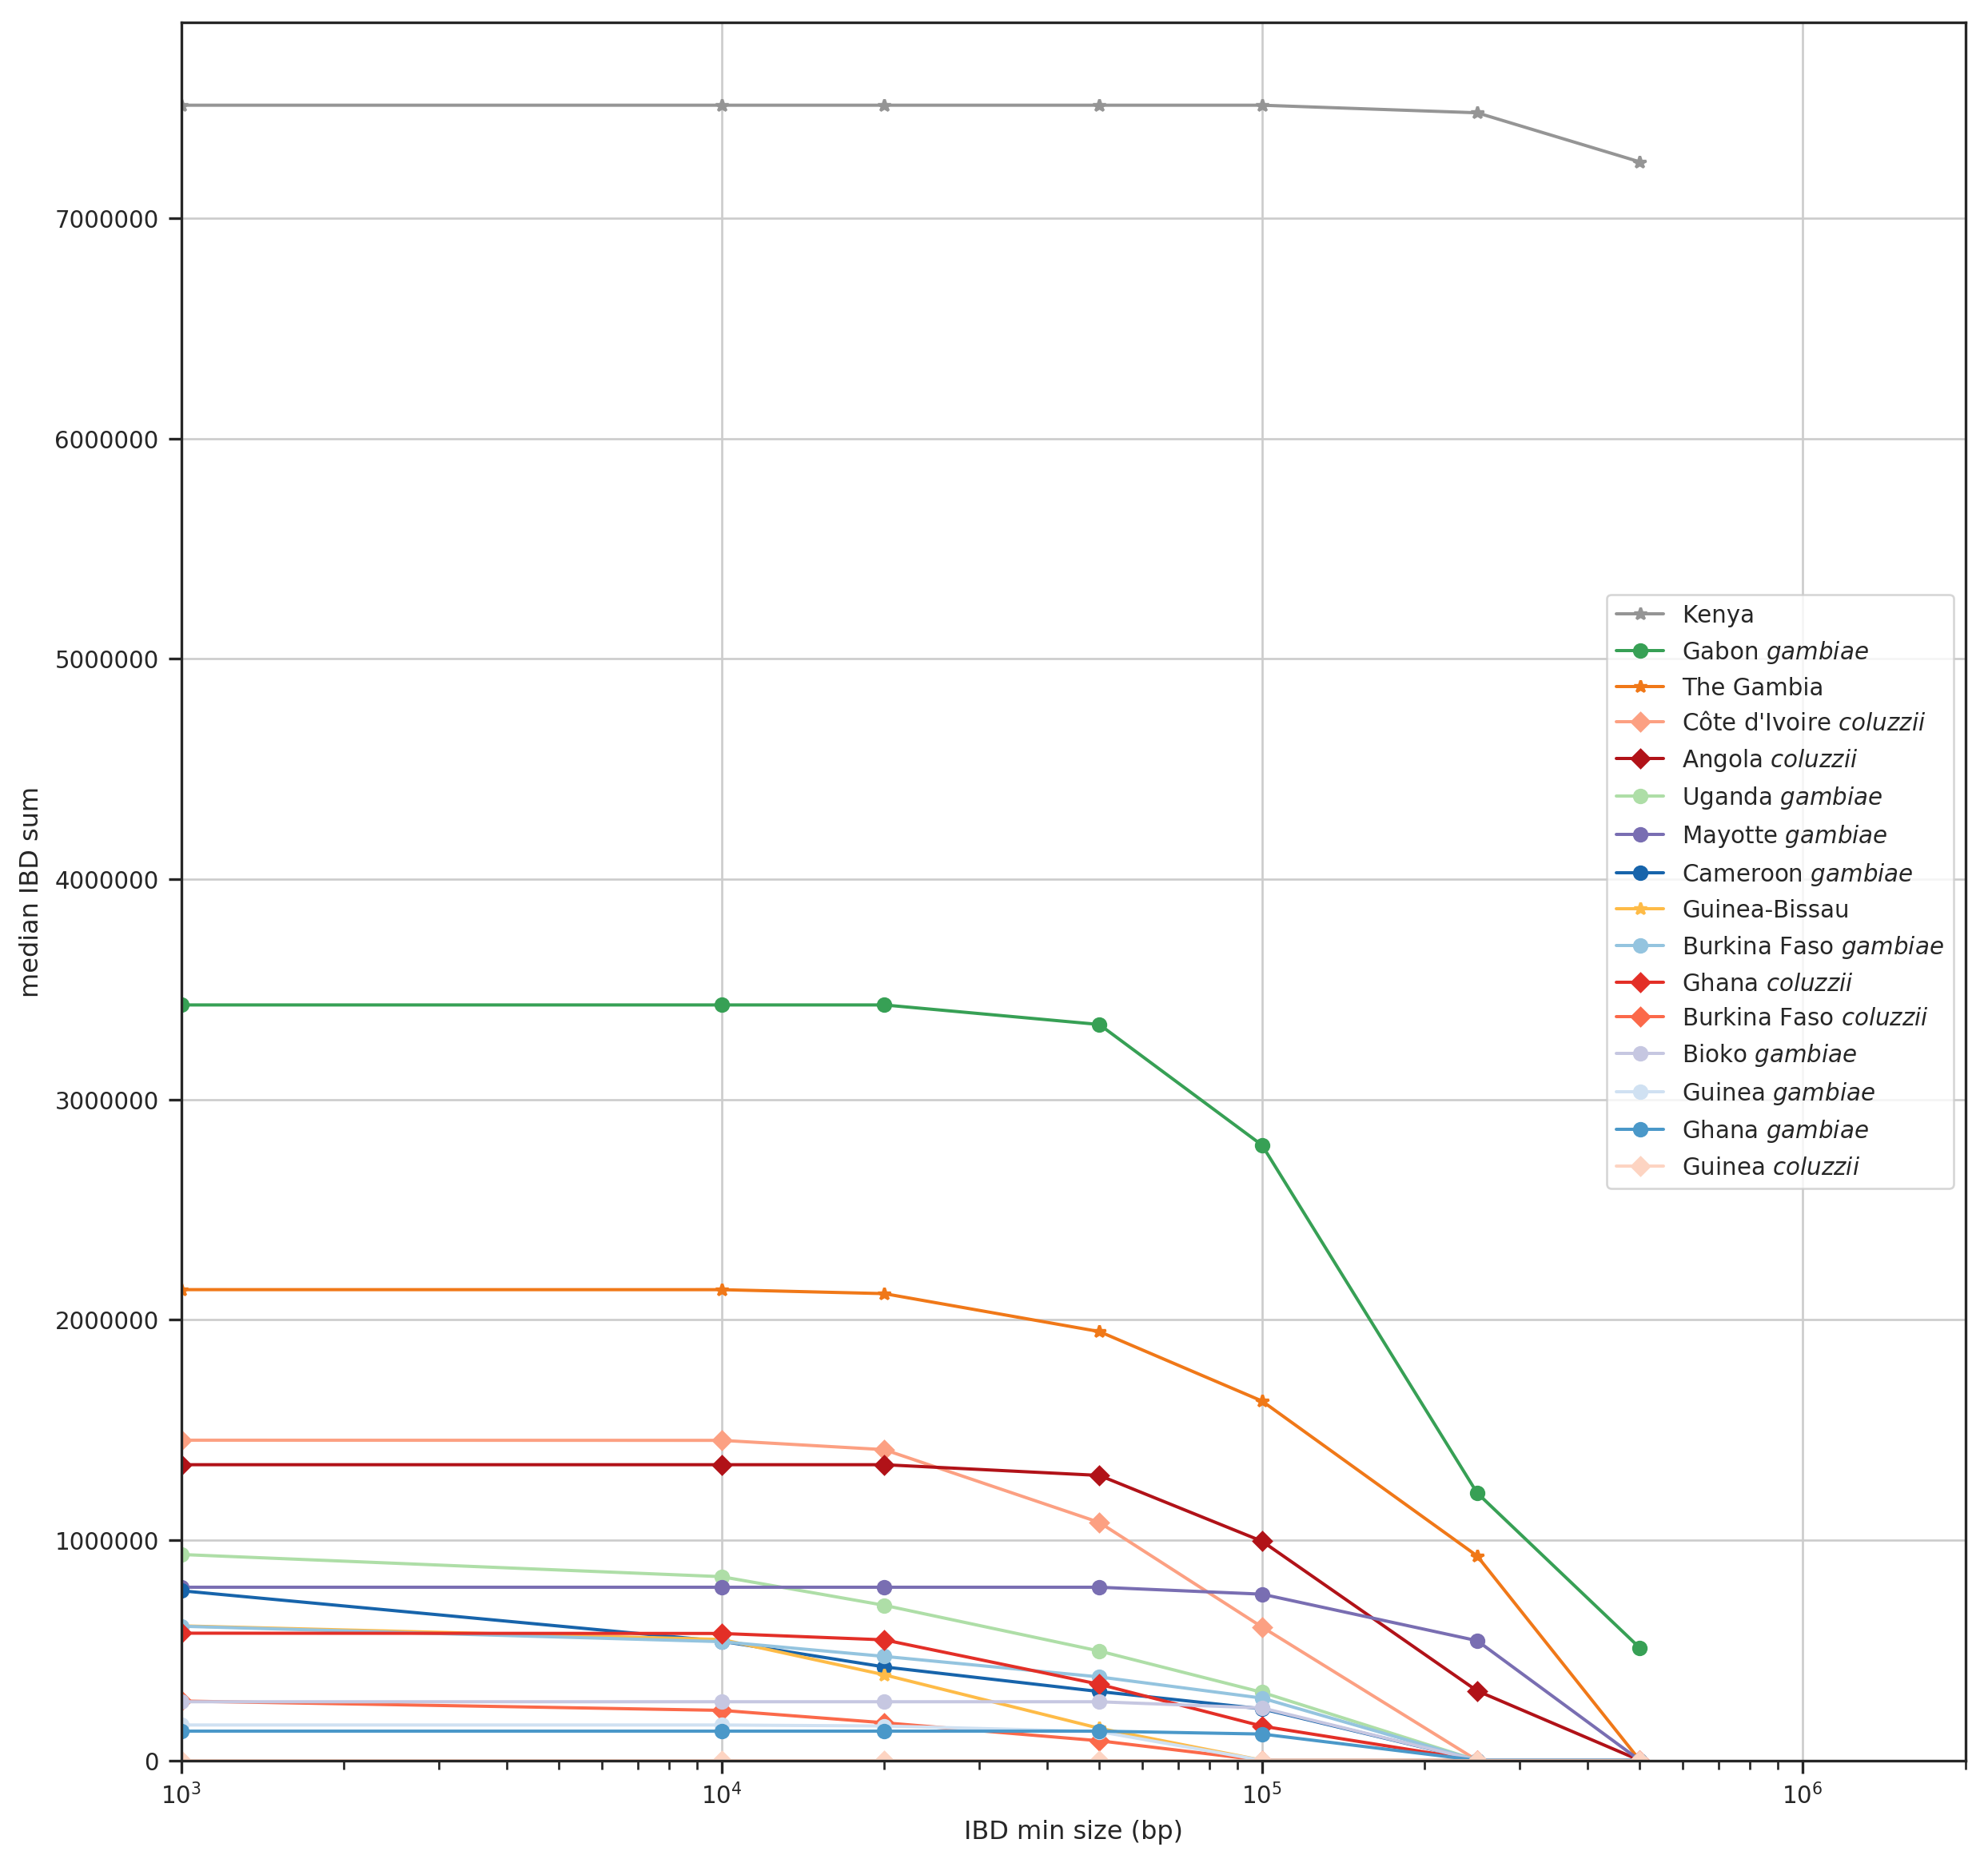

In [111]:
fig, ax = plt.subplots(figsize=(12, 12))

for ix, pop in enumerate(sorted_med_ibd.index):
#for ix, pop in enumerate(["AOcol"]):
        
    ibd = tab.loc[pop]
    ax.plot(
        ibd.index.values, 
        ibd["median"], 
        alpha=1.0, 
        color=phase2_ar1.pop_colors[pop],
        marker=marker_style[pop],
        label=phase2_ar1.pop_labels[pop])
    
    ax.set_xscale("log", nonposx='clip')

ax.set_xlim((10**3, 2 * 10**6))
ax.set_ylim(bottom=0)
ax.grid(True)

leg = ax.legend()
ax.set_ylabel("median IBD sum")
ax.set_xlabel("IBD min size (bp)")

# for lh in leg.legendHandles: 
#     lh.set_alpha(1.0)

# fig.savefig(
#     "../artwork/ibd/ibd_all_populations.png", 
#     bbox_inches="tight", 
#     dpi=300)